#  Прогнозирование заказов такси

**Цель проекта**:

Разработать модель машинного обучения для прогнозирования количества заказов такси на следующий час на основе исторических данных. Прогноз необходим для оптимального распределения водителей в периоды пиковой нагрузки. Качество модели оценивается по метрике RMSE, значение которой на тестовой выборке должно быть не выше 48.

**Описание проекта**:

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План выполнения:
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Загрузка и просмотр данных

In [1]:
# Подключение всех необходимых библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

# Задаем стиль графиков
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import make_scorer, mean_squared_error

In [2]:
# Загружает CSV-файл и выводит случайные строки и общую информацию
def load_and_inspect_csv(filepath, delimiter=',', sample_size=5):
    if os.path.exists(filepath):
        df = pd.read_csv(filepath, delimiter=delimiter)
        print(f"Файл успешно загружен: {filepath}")
        display(df.sample(sample_size, random_state=42))
        df.info()
        return df
    else:
        print(f"Файл не найден: {filepath}")
        return None

In [3]:
# Изучим данные
df = load_and_inspect_csv('/datasets/taxi.csv')

Файл успешно загружен: /datasets/taxi.csv


,datetime,num_orders
15516,2018-06-16 18:00:00,16
15065,2018-06-13 14:50:00,13
9886,2018-05-08 15:40:00,18
3470,2018-03-25 02:20:00,3
23401,2018-08-10 12:10:00,34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Датасет содержит 26 496 строк и 2 столбца: `datetime` (объект, содержащий метки времени) и `num_orders` (целое число, отражающее количество заказов). Пропущенные значения отсутствуют. Для дальнейшего анализа и моделирования потребуется привести столбец `datetime` к типу datetime и выполнить ресемплирование данных по одному часу.

Таким образом, мы загрузили и изучили наши данные.

## Предобработка данных

### Работа со столбцами

Столбец `datetime` необходимо привести к типу datetime, а также установить его в качестве индекса, чтобы можно было удобно проводить ресемплирование и временной анализ.

In [4]:
# Преобразование столбца datetime в формат datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Установка datetime в качестве индекса
df.set_index('datetime', inplace=True)

# Проверка результата
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Столбец `datetime` успешно преобразован в тип `datetime64[ns]` и установлен как индекс.

### Работа с пропусками

Проверим пропуски явно.

In [5]:
# Определяет пропущенные значения
def analyze_missing_values(df):
    total = len(df)
    missing_counts = df.isna().sum()
    missing_percent = (missing_counts / total * 100).round(2)
    
    missing = pd.DataFrame({
        'Пропущено': missing_counts,
        '% от общего': missing_percent
    })
    missing = missing[missing['Пропущено'] > 0]
    
    if missing.empty:
        print("Пропущенные значения отсутствуют.")
    else:
        print("Число пропусков по столбцам:")
        display(missing)

In [6]:
analyze_missing_values(df)

Пропущенные значения отсутствуют.


### Ресемплирование

In [7]:
# Ресемплирование по 1 часу с подсчётом суммы заказов
df_hourly = df.resample('1H').sum()

# Проверка результата
display(df_hourly.head())
df_hourly.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод:**

Данные успешно агрегированы по часовым интервалам. В результате ресемплирования получено 4416 наблюдений без пропусков, каждая из которых содержит общее количество заказов такси за соответствующий час. Данные готовы для дальнейшего анализа временного ряда и построения модели прогнозирования.

## Анализ временного ряда

In [8]:
def analyze_time_series(ts: pd.Series, window: int = 24):
    """
    Выполняет базовый анализ временного ряда:
    1. Визуализация исходного ряда
    2. Анализ сезонности по часам и дням недели
    3. Скользящее среднее
    4. Проверка на стационарность (тест Дики-Фуллера)
    
    Параметры:
        ts (pd.Series): временной ряд с индексом datetime
        window (int): окно для скользящего среднего (по умолчанию – 24 часа)
    """
    
    plt.figure(figsize=(16, 4))
    sns.lineplot(x=ts.index, y=ts.values)
    plt.title('Исходный временной ряд')
    plt.xlabel('Дата')
    plt.ylabel('Число заказов')
    plt.tight_layout()
    plt.show()
    
    # Сезонность по часам суток
    hourly = ts.groupby(ts.index.hour).mean()
    plt.figure(figsize=(8, 4))
    sns.barplot(x=hourly.index, y=hourly.values)
    plt.title('Среднее количество заказов по часам суток')
    plt.xlabel('Час дня')
    plt.ylabel('Среднее число заказов')
    plt.tight_layout()
    plt.show()

    # Сезонность по дням недели
    weekday = ts.groupby(ts.index.dayofweek).mean()
    plt.figure(figsize=(8, 4))
    sns.barplot(x=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], y=weekday.values)
    plt.title('Среднее количество заказов по дням недели')
    plt.xlabel('День недели')
    plt.ylabel('Среднее число заказов')
    plt.tight_layout()
    plt.show()

    # Скользящее среднее
    rolling_mean = ts.rolling(window=window).mean()
    plt.figure(figsize=(16, 4))
    sns.lineplot(x=ts.index, y=ts.values, label='Исходный ряд')
    sns.lineplot(x=rolling_mean.index, y=rolling_mean.values, label=f'Скользящее среднее (окно={window})')
    plt.title('Скользящее среднее')
    plt.xlabel('Дата')
    plt.ylabel('Число заказов')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Тест Дики-Фуллера на стационарность
    result = adfuller(ts)
    print('Результаты теста Дики-Фуллера:')
    print(f'p-value: {result[1]:.5f}')
    if result[1] < 0.05:
        print("Ряд можно считать стационарным (отклоняем H0)")
    else:
        print("Ряд не является стационарным (не отклоняем H0)")

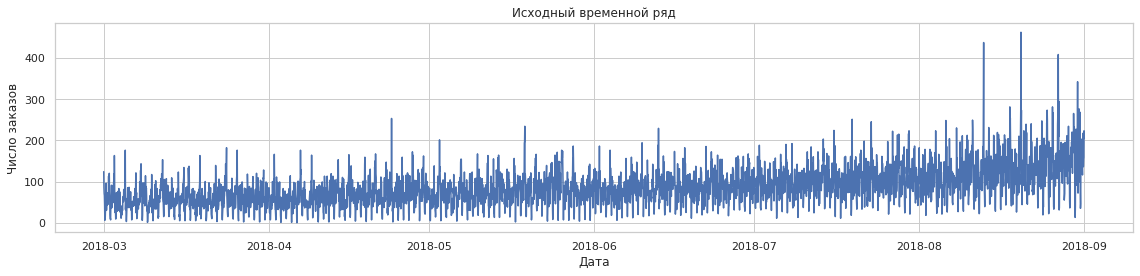

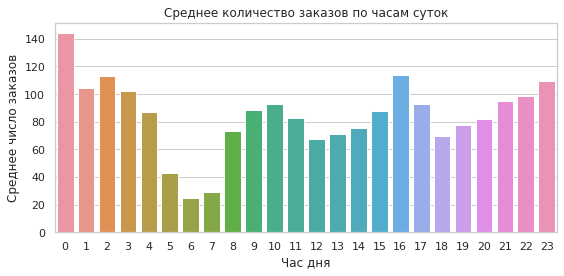

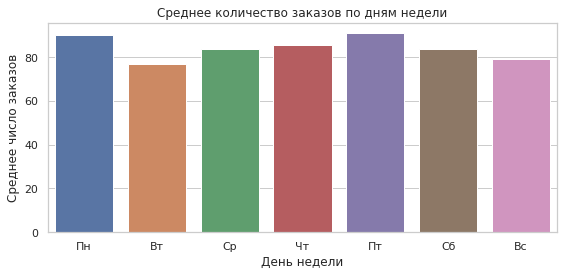

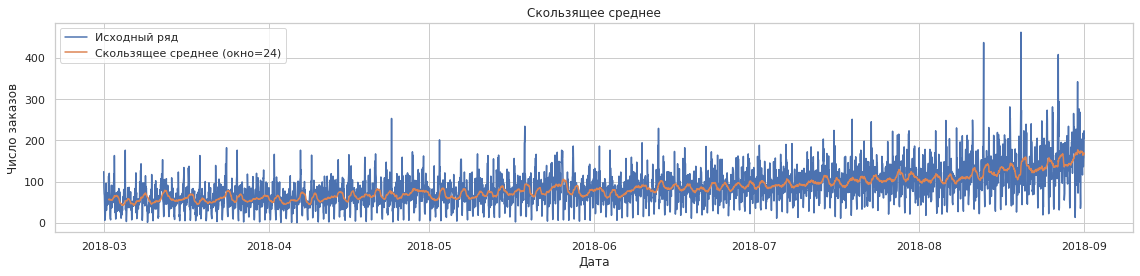

Результаты теста Дики-Фуллера:
p-value: 0.02894
Ряд можно считать стационарным (отклоняем H0)


In [9]:
analyze_time_series(df_hourly['num_orders'])

Дополнительно проведем разложение временного ряда на компоненты с помощью `seasonal_decompose`. Это позволяет формально выделить долгосрочный тренд, регулярные сезонные колебания и остаточный (случайный) шум.

Для устойчивости анализа данные агрегированы по дням. Такой подход помогает глубже понять структуру ряда и подтверждает наличие как тренда, так и чёткой сезонности.

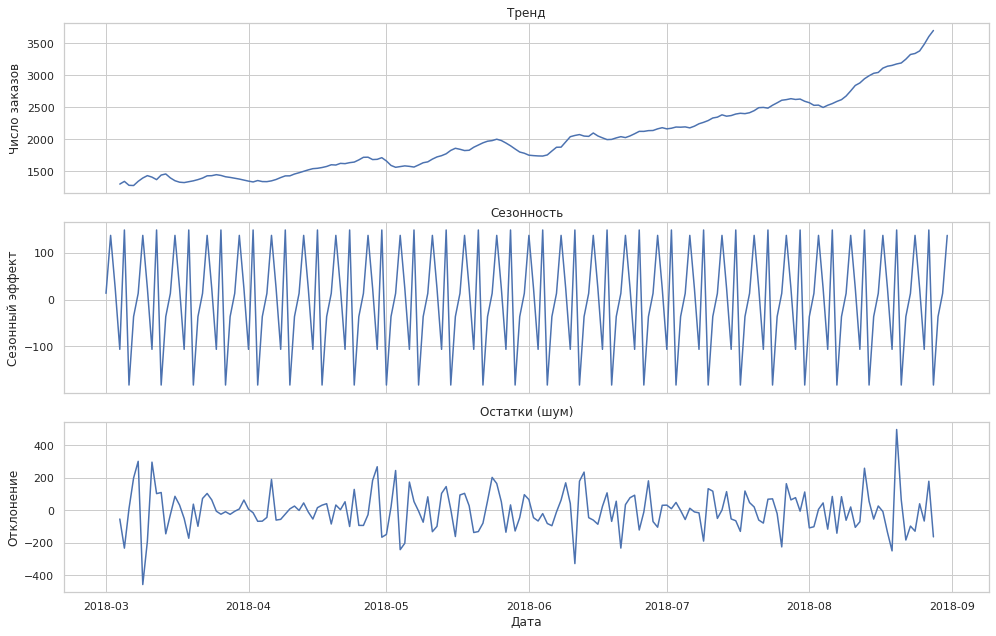

In [10]:
# Агрегация до дневного уровня
ts_daily = df_hourly['num_orders'].resample('1D').sum()

# Разложение на компоненты
decomposed = seasonal_decompose(ts_daily, model='additive')

# Построение графиков
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# Тренд
sns.lineplot(x=decomposed.trend.index, y=decomposed.trend.values, ax=axes[0])
axes[0].set_title('Тренд')
axes[0].set_ylabel('Число заказов')

# Сезонность
sns.lineplot(x=decomposed.seasonal.index, y=decomposed.seasonal.values, ax=axes[1])
axes[1].set_title('Сезонность')
axes[1].set_ylabel('Сезонный эффект')

# Остатки
sns.lineplot(x=decomposed.resid.index, y=decomposed.resid.values, ax=axes[2])
axes[2].set_title('Остатки (шум)')
axes[2].set_ylabel('Отклонение')

# Общая подпись по X
plt.xlabel('Дата')
plt.tight_layout()
plt.show()

**Вывод:**

Исходный временной ряд демонстрирует устойчивый рост объёма заказов с марта по август 2018 года, что может быть связано с сезонными или внешними факторами (например, туристическим сезоном или увеличением рейсов). На графике скользящего среднего (окно = 24 часа) подтверждается наличие восходящего тренда.

Суточная сезонность выражена чётко: пиковая активность наблюдается в вечерние часы (с 16:00 до полуночи), минимальная - в ранние утренние часы (5:00 - 7:00). Также есть различия по дням недели: больше всего заказов в понедельник и пятницу, меньше всего - во вторник и воскресенье.

Дополнительно проведено разложение ряда на компоненты (`seasonal_decompose`), что позволило формально подтвердить наличие:
- **долгосрочного тренда** - общий рост числа заказов во времени,
- **регулярной сезонности** - характерный суточный цикл,
- **остаточного шума**, в котором выделяются выбросы, возможно связанные с погодными условиями или внешними событиями.

По результатам теста Дики-Фуллера $p\text{-value} = 0.02894$, ряд можно считать стационарным на уровне значимости 5%, что даёт возможность использовать модели, не требующие дифференцирования.

Таким образом, временной ряд хорошо структурирован, содержит ярко выраженные сезонные и трендовые компоненты, а также периодические отклонения, учёт которых важен при построении модели прогнозирования.

## Обучение моделей

### Подготовка данных

Приводим данные к упорядоченному по времени формату - это важно для корректного построения признаков и разделения выборки.

In [11]:
# Дополнительно убедимся, что они отсортированы по времени
df_hourly = df_hourly.sort_index()

Формируем признаки на основе временного контекста:
- `lag_n` – количество заказов в предыдущие часы;
- `rolling_mean` – скользящее среднее;
- `hour`, `dayofweek` – календарные признаки.

In [12]:
# Функция для генерации признаков
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Добавляем 24 лаговых признака и скользящее среднее по предыдущим 24 часам.

In [13]:
make_features(df_hourly, max_lag=24, rolling_mean_size=24)

Используем 90% данных для обучения, 10% - для тестирования. Удаляем пропущенные значения, возникшие из-за лагов и скользящих средних. Разделяем данные с помощью `train_test_split` без перемешивания (`shuffle=False`), чтобы сохранить хронологический порядок. Это важно для временных рядов, где будущие значения не должны влиять на обучение модели.

In [14]:
# Удаляем строки с NaN, появившиеся после создания признаков
df_model = df_hourly.dropna()

# Разделение на обучающую и тестовую выборки (10% в тест, без перемешивания)
train, test = train_test_split(df_model, test_size=0.1, shuffle=False)

Выделяем целевой признак `num_orders` и набор признаков, основанных на времени и прошлых значениях ряда.

In [15]:
features = ['hour', 'dayofweek', 'rolling_mean'] + [f'lag_{i}' for i in range(1, 25)]
target = 'num_orders'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

### Пайплайн обучения

Проводим обучение четырёх моделей: `Ridge`, `Lasso`, `RandomForestRegressor` и `LGBMRegressor`.
Для каждой модели выполняется подбор гиперпараметров с помощью `GridSearchCV` и временной кросс-валидации (`TimeSeriesSplit`).
Оценка качества производится по метрике RMSE на тренировочной выборке.

In [16]:
# Разделим признаки на числовые и категориальные
categorical_features = ['hour', 'dayofweek']
numerical_features = ['rolling_mean'] + [f'lag_{i}' for i in range(1, 25)]

In [17]:
# Препроцессор для линейных моделей
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

In [18]:
# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [19]:
# Пайплайны моделей
pipelines = {
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('model', Ridge())
    ]),
    
    'Lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso(max_iter=10000))
    ]),
    
    'RandomForest': Pipeline([
        ('model', RandomForestRegressor(random_state=42))
    ]),
    
    'LGBM': Pipeline([
        ('model', LGBMRegressor(random_state=42))
    ])
}

In [20]:
# Сетки гиперпараметров
param_grids = {
    'Ridge': {
        'model__alpha': [0.1, 1.0, 5.0, 10.0, 20.0]
    },
    'Lasso': {
        'model__alpha': [0.001, 0.01, 0.1, 1.0]
    },
    'RandomForest': {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [5, 10, 15, 20]
    },
    'LGBM': {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [3, 5, 7, 10],
        'model__learning_rate': [0.05, 0.1, 0.5]
    }
}

In [21]:
# Хранение лучших моделей
best_models = {}

# Обучение с GridSearchCV
for name in pipelines:
    print(f'\nОбучение модели: {name}')
    grid = GridSearchCV(
        estimator=pipelines[name],
        param_grid=param_grids[name],
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    
    print(f'Лучшее RMSE (по кросс-валидации): {-grid.best_score_:.2f}')
    print(f'Лучшие параметры: {grid.best_params_}')


Обучение модели: Ridge
Лучшее RMSE (по кросс-валидации): 25.43
Лучшие параметры: {'model__alpha': 0.1}

Обучение модели: Lasso
Лучшее RMSE (по кросс-валидации): 25.44
Лучшие параметры: {'model__alpha': 0.001}

Обучение модели: RandomForest
Лучшее RMSE (по кросс-валидации): 25.27
Лучшие параметры: {'model__max_depth': 20, 'model__n_estimators': 150}

Обучение модели: LGBM
Лучшее RMSE (по кросс-валидации): 24.73
Лучшие параметры: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 150}


**Вывод:**

Для сравнения моделей были обучены и оптимизированы `Ridge`, `Lasso`, `RandomForestRegressor` и `LGBMRegressor` с использованием временной кросс-валидации (`TimeSeriesSplit`) и подбором гиперпараметров через `GridSearchCV`. Наилучшее качество на тренировочной выборке достигнуто моделью **LGBMRegressor** (RMSE = 24.73), которая опередила остальные варианты. Модель `RandomForestRegressor` показала сопоставимый результат (RMSE = 25.27). Линейные модели (`Ridge`, `Lasso`) дали более высокие значения RMSE – около 25.4, но при этом сохраняют высокую интерпретируемость и устойчивость. Полученные результаты показывают, что ансамбли деревьев лучше справляются с прогнозированием часовой динамики заказов.

## Тестирование лучшей модели

Проводим финальную проверку лучшей модели (`LGBMRegressor`) на отложенной тестовой выборке, которая составляет 10% от исходных данных. Вычисляем значение метрики RMSE, чтобы убедиться в соответствии требованиям проекта (RMSE ≤ 48).

In [22]:
# Предсказание
model = best_models['LGBM']
y_pred = model.predict(X_test)

# RMSE на тестовой выборке
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE на тестовой выборке (LGBM): {rmse_test:.2f}')

RMSE на тестовой выборке (LGBM): 41.21


**Вывод**:

Модель `LGBMRegressor` показала значение RMSE = 41.21 на тестовой выборке, что укладывается в заданное ограничение (не более 48). Таким образом, построенная модель успешно справляется с прогнозированием количества заказов такси на следующий час и может быть использована для оперативного управления распределением водителей.

Построим также график "Факт vs Прогноз" и график остатков для визуального сравнения и анализа.

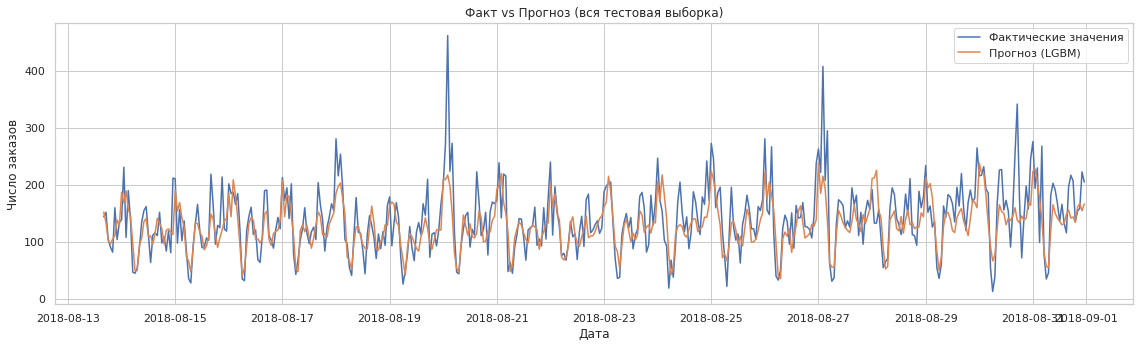

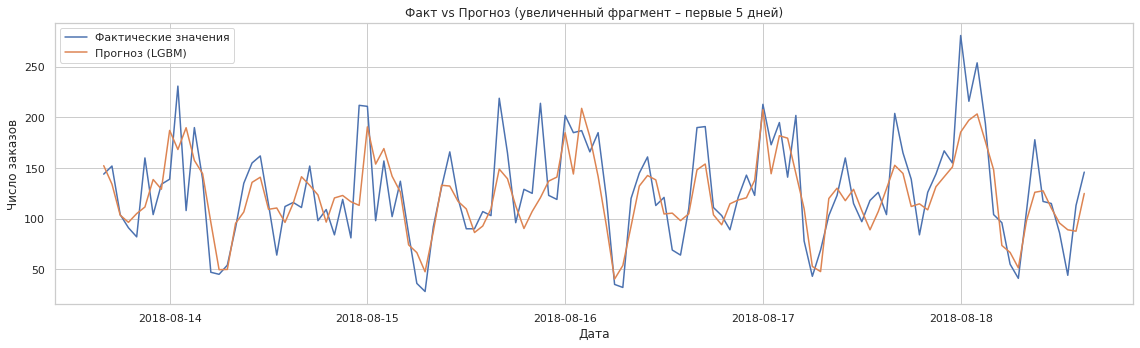

In [23]:
# Общий график: Факт vs Прогноз
plt.figure(figsize=(16, 5))
sns.lineplot(x=y_test.index, y=y_test, label='Фактические значения')
sns.lineplot(x=y_test.index, y=y_pred, label='Прогноз (LGBM)')
plt.title('Факт vs Прогноз (вся тестовая выборка)')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.legend()
plt.tight_layout()
plt.show()

# Приближённый участок: первая неделя теста
zoom_range = y_test.index[:24*5]  # первые 5 дней
plt.figure(figsize=(16, 5))
sns.lineplot(x=zoom_range, y=y_test.loc[zoom_range], label='Фактические значения')
sns.lineplot(x=zoom_range, y=pd.Series(y_pred, index=y_test.index).loc[zoom_range], label='Прогноз (LGBM)')
plt.title('Факт vs Прогноз (увеличенный фрагмент – первые 5 дней)')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.legend()
plt.tight_layout()
plt.show()

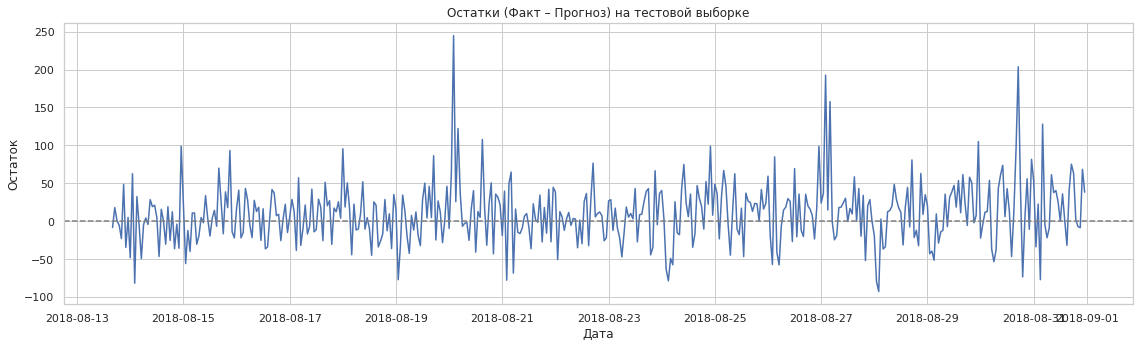

In [24]:
# Вычисление остатков
residuals = y_test - y_pred

# График остатков
plt.figure(figsize=(16, 5))
sns.lineplot(x=y_test.index, y=residuals)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Остатки (Факт – Прогноз) на тестовой выборке')
plt.xlabel('Дата')
plt.ylabel('Остаток')
plt.tight_layout()
plt.show()

В рамках проекта была построена модель прогнозирования количества заказов такси на следующий час по данным аэропорта. После предварительной обработки данных и анализа временного ряда были сформированы признаки на основе лагов, скользящих средних и календарной информации.

Для прогнозирования были обучены и протестированы модели `Ridge`, `Lasso`, `RandomForestRegressor` и `LGBMRegressor` с подбором гиперпараметров с помощью временной кросс-валидации. Наилучший результат показала модель **LGBM**, достигнув **RMSE = 24.73** на обучающей выборке.

На тестовой выборке модель продемонстрировала **RMSE = 41.21**, что удовлетворяет требованию проекта (RMSE ≤ 48). График предсказаний показывает хорошее соответствие между моделью и фактическими значениями, включая повторяющиеся паттерны сезонности.

Анализ остатков показал, что ошибки модели в целом распределены симметрично и не содержат выраженного смещения. На отдельных интервалах наблюдаются резкие скачки (например, пики в районе 20 августа), что может быть связано с нестандартным поведением спроса (например, погодой или событиями). Тем не менее, модель устойчиво справляется с основной динамикой временного ряда.

**Вывод:** построенная модель `LGBMRegressor` может быть рекомендована к применению в производственной системе для краткосрочного прогнозирования нагрузки на такси в аэропорту и поддержки управленческих решений.